# How-To Define Areas of Interest and Aggregate Fixation Metrics

After mapping gaze to the environment, e.g. by using the [Reference Image Mapper](https://docs.pupil-labs.com/invisible/explainers/enrichments/#reference-image-mapper), it is a common goal to compare gaze behaviour on different objects of interest within the environment. An easy way to facilitate this using the Reference Image Mapper, is to define areas of interest (AOIs) in the reference image and to compare them with various gaze metrics like e.g. dwell time. 

In this guide we will show you how to mark AOIs on a reference image, how to label which AOI a fixation was made on, and how to aggregate metrics from fixation data inside these AOIs.

As an example we will use the recordings and enrichment of the art gallery study available in the [demo workspace](https://cloud.pupil-labs.com/workspace/78cddeee-772e-4e54-9963-1cc2f62825f9/project/cdfde655-3c8a-45c5-b6e2-5d5754d7a4f0/edit). We will address questions like "How many visitors looked at each painting?", "How soon after arriving did visitors look at each painting?", and "How long did visitors look at each painting?".

## Dependencies of this Guide

You can find all code from this guide [here](https://github.com/pupil-labs/pupil-docs/blob/master/src/invisible/how-tos/advanced-analysis/gaze-metrics-in-aois/). To execute it you need to have the following libraries installed:

```pip install matplotlib pandas opencv-python seaborn```

Download the Reference Image Mapper enrichment called `multiple_paintings_standing` from the demo workspace [here](https://cloud.pupil-labs.com/workspace/78cddeee-772e-4e54-9963-1cc2f62825f9/project/cdfde655-3c8a-45c5-b6e2-5d5754d7a4f0/enrich?search=multiple_paintings_standing) and unpack it in a `data` folder next to the code.

## Define AOIs in the Reference Image
The reference image `reference_image.jpeg` is located inside the enrichment folder. 

An easy way to define AOIs in the image is to use the `cv2.selectROIs` method from [OpenCV](https://docs.opencv.org/3.4/d7/dfc/group__highgui.html#ga0f11fad74a6432b8055fb21621a0f893).
When executing this method, a window with the reference image will appear.
Mark the AOIs by dragging rectangles over the areas you want your AOIs to cover. Hit the space key after each AOI and once you are done close the selection with the escape key.


In [ ]:
import cv2

# load the reference image
reference_image_bgr = cv2.imread("data/reference_image.jpeg")
reference_image = cv2.cvtColor(reference_image_bgr, cv2.COLOR_BGR2RGB)

# resize the image before labelling AOIs makes the image stay in the screen boundaries
scaling_factor = 0.25
scaled_image = reference_image_bgr.copy()
scaled_image = cv2.resize(
    scaled_image, dsize=None, fx=scaling_factor, fy=scaling_factor
)

# mark the AOIs
scaled_aois = cv2.selectROIs("AOI Annotation", scaled_image)
cv2.destroyAllWindows()

# scale back the position of AOIs
aois = scaled_aois / scaling_factor
print(scaled_aois)

If you want to use the same AOIs as this guide is using, you can uncomment the following code rather than defining your own AOIs.

In [28]:
import numpy as np

# aois = np.array(
#     [[ 512.,  136.,  588.,  572.],
#     [1448.,  700.,  392.,  456.],
#     [1872.,  300.,  652.,  864.],
#     [3212.,  232.,  504.,  492.],
#     [2584.,  788.,  456.,  576.],
#     [3044.,  928.,  452.,  416.],
#     [ 892., 1256., 1636.,  880.],
#     [2628., 1388.,  844.,  648.],
#     [ 696., 2492.,  428.,  476.],
#     [1232., 2304.,  364.,  408.],
#     [1980., 2280.,  556.,  700.],
#     [2576., 2064.,  856.,  936.]]
# )

## Overlaying Areas of Interest on the Reference Image
Now, we visually check whether the AOIs we defined match up with our reference image. We define a `plot_color_patches` function, which we will use throughout the rest of this guide.

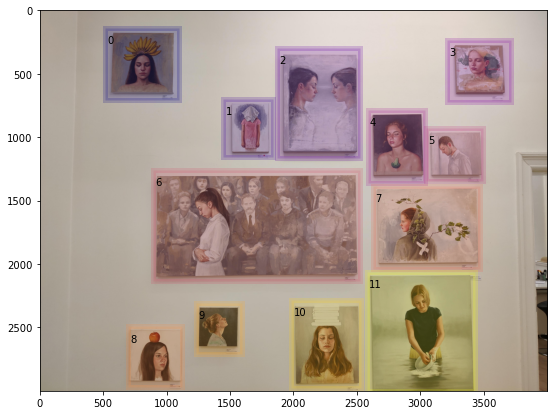

In [58]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import patches
import seaborn as sns


# list of the painting ids as names
# paintings = [idx for idx in range(len(aois))]

# plot the reference image and overlay the AOIS
plt.figure(figsize=(10, 7))
plt.imshow(reference_image)

# define a function to draw rectangles on the image
def plot_color_patches(
    patch_position,
    patch_values,
    ax,
    alpha=0.2,
):
    # normalize patch values
    patch_values = patch_values.astype(np.float32)
    patch_values -= patch_values.min()
    patch_values /= patch_values.max()

    colors = mpl.cm.get_cmap("plasma")

    for patch_idx, (aoi, value) in enumerate(zip(patch_position, patch_values)):
        ax.add_patch(
            patches.Rectangle(
                aoi,
                *aoi[2:],
                alpha=alpha,
                facecolor=colors(value),
                edgecolor=colors(value),
                linewidth=5
            )
        )
        ax.text(aoi[0] + 20, aoi[1] + 120, f"{patch_idx}", color="black")

plot_color_patches(aois, np.arange(len(aois)), plt.gca())

## Map Fixations to AOIs

Next up, we want to match the fixation coordinates to the AOIs. This is comparable to asking for every x/y coordinate pair that defines a fixation if that pair is inside any of the rectangles.

In [31]:
import pandas as pd

fixations = pd.read_csv("data/fixations.csv")
# filter for fixations that are in the reference image
fixations = fixations[fixations["fixation detected in reference image"]]

fixations["AOI"] = None

def check_in_rect(fixation_data, rectangle_coordinates):
    rect_x, rect_y, rect_width, rect_height = rectangle_coordinates
    x_hit = fixation_data["fixation x [px]"].between(rect_x, rect_x + rect_width)
    y_hit = fixation_data["fixation y [px]"].between(rect_y, rect_y + rect_height)
    return x_hit & y_hit

for aoi_id, aoi in enumerate(aois):
    fixations.loc[check_in_rect(fixations, aoi), "AOI"] = paintings[aoi_id]

fixations.head()

,section id,recording id,fixation id,start timestamp [ns],end timestamp [ns],duration [ms],fixation detected in reference image,fixation x [px],fixation y [px],AOI
0,3cd54e6f-f12e-468c-9a7b-6afffd5f0379,54a0deee-23dd-48f4-806e-6fdb519d6a7c,248,1636035560036503914,1636035560236515914,200,True,2419.0,2138.0,None
1,3cd54e6f-f12e-468c-9a7b-6afffd5f0379,54a0deee-23dd-48f4-806e-6fdb519d6a7c,249,1636035560256651914,1636035560480505914,223,True,2224.0,1717.0,6
2,3cd54e6f-f12e-468c-9a7b-6afffd5f0379,54a0deee-23dd-48f4-806e-6fdb519d6a7c,250,1636035560500491914,1636035560740669914,240,True,2427.0,1559.0,6
3,3cd54e6f-f12e-468c-9a7b-6afffd5f0379,54a0deee-23dd-48f4-806e-6fdb519d6a7c,251,1636035560776494914,1636035560972502914,196,True,1935.0,1119.0,2
4,3cd54e6f-f12e-468c-9a7b-6afffd5f0379,54a0deee-23dd-48f4-806e-6fdb519d6a7c,252,1636035561008557914,1636035561168510914,159,True,2828.0,1668.0,7


You can now see the new column "AOI". This column indicates whether gaze fell inside a given AOI.

## Aggregating Fixation Metrics Inside AOIs

Using the defined AOIs and the mapped fixation data we can now calculate various metrics to compare gaze behaviour on the AOIs.

### AOI Hit Rate

The Hit Rate of an AOI is defined as the proportion of subjects that looked at the AOI at least once. 
A Hit Rate of 100% means, every subject we recorded looked at the AOI, a Hit Rate of 50% indicates that only every second subject looked at the AOI, etc.

In [69]:
hits = fixations.groupby(["recording id", "AOI"]).size() > 0
hit_rate = hits.groupby("AOI").sum() / fixations["recording id"].nunique() * 100

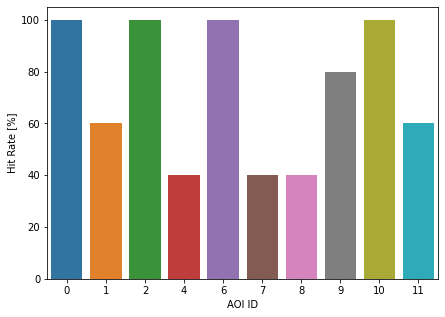

In [55]:
plt.figure(figsize=(7, 5))

sns.barplot(x=hit_rate.index, y=hit_rate)

plt.xlabel("AOI ID")
plt.ylabel("Hit Rate [%]");

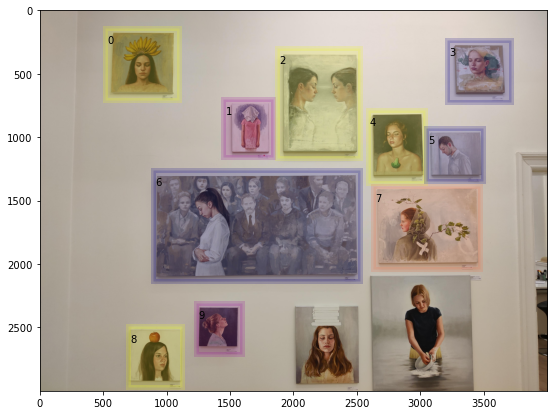

In [59]:
plt.figure(figsize=(10, 7))
plt.imshow(reference_image)

# define a colorscheme for the patches
aoi_colors = mpl.cm.get_cmap("plasma")
n_colorsteps = len(aois) - 1

# display the AOI patches
plot_color_patches(aois, hit_rate, plt.gca())

# Time to First Contact
Time to First Contact measures how long it took observers to look at an AOI for the first time. Short times to first contact mean that the observers looked at the AOI early during the section.

We can compute time to first contact as the difference between the time when the first fixation was registered on an AOI and the time when the section started. So first, we need the information when each section started.

In [8]:
# loading sections
sections = pd.read_csv(f"{path_to_reference_image_mapper}/sections.csv")
sections.head()

# create a new column in the fixation dataframe
fixations["aligned timestamp [s]"] = None

# compute the difference for the respective section
for section in sections["section id"]:
    section_idx = fixations[fixations["section id"] == section].index
    section_start_time = sections.loc[
        sections["section id"] == section, "section start time [ns]"
    ].values
    # update the value of the aligned time stamp
    fixations.loc[section_idx, "aligned timestamp [s]"] = (
        fixations.loc[section_idx, "start timestamp [ns]"] - section_start_time
    ) / 1e9

## Extract Time to First Contact
Next, we aggregate the fixation data by section id and AOI, and extract the lowest value from the "aligned timestamp [s]" column. This is the time when the very first fixation on that AOI appeared in this session.

In [9]:
first_contact = pd.DataFrame(
    fixations.groupby(["section id", "AOI"]).min()["aligned timestamp [s]"]
)
first_contact.reset_index(inplace=True)

first_contact.head()

,section id,AOI,aligned timestamp [s]
0,3cd54e6f-f12e-468c-9a7b-6afffd5f0379,0,2.848527
1,3cd54e6f-f12e-468c-9a7b-6afffd5f0379,1,2.588504
2,3cd54e6f-f12e-468c-9a7b-6afffd5f0379,2,0.656495
3,3cd54e6f-f12e-468c-9a7b-6afffd5f0379,6,0.136652
4,3cd54e6f-f12e-468c-9a7b-6afffd5f0379,7,0.888558


## Visualize Time to First Contact

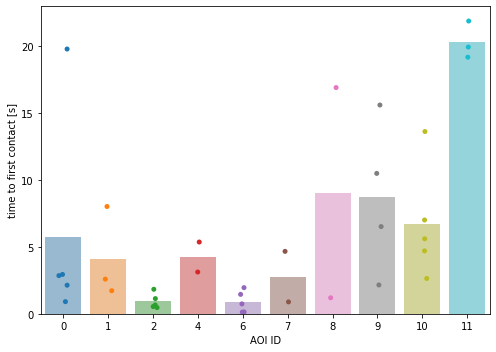

In [10]:
# create the figure
first_contact_fig = plt.figure(figsize=(7, 5))

# plot the mean values as bar plots
sns.barplot(
    x="AOI",
    y="aligned timestamp [s]",
    data=first_contact,
    ci=None,
    ax=plt.gca(),
    alpha=0.5,
)
# add individual data as dots
sns.stripplot(
    x="AOI",
    y="aligned timestamp [s]",
    data=first_contact,
    ax=plt.gca(),
)
# set title and axis labels
plt.ylabel("time to first contact [s]")
plt.xlabel("AOI ID")
plt.tight_layout()

# Dwell Time

Dwell Time describes the total time an observer has looked at a given AOI. We can find the dwell time by summing up the durations of all fixations we detected, seperately for each AOI. Again, we group our data frame, and then sum up all the fixation duration we recorded during our study.

In [11]:
dwell = fixations.groupby(["section id", "AOI"]).sum()["duration [ms]"]
dwell = pd.DataFrame(dwell).sort_values("AOI")
dwell.reset_index(inplace=True)

# translate the dwell time in milliseconds to seconds
dwell["duration [s]"] = dwell["duration [ms]"] / 1000

dwell.head()

,section id,AOI,duration [ms],duration [s]
0,3cd54e6f-f12e-468c-9a7b-6afffd5f0379,0,544.0,0.544
1,701607c8-fd13-4c98-b5cd-2bf7e1b5818a,0,1016.0,1.016
2,93f3ae11-30aa-45a9-b5bd-57b0ed6bad95,0,2149.0,2.149
3,5ee66696-5b84-4814-bb13-b96dee92dfba,0,408.0,0.408
4,89011032-f86b-41fa-a7c7-1c39e734113a,0,1003.0,1.003


## Visualize Dwell Time

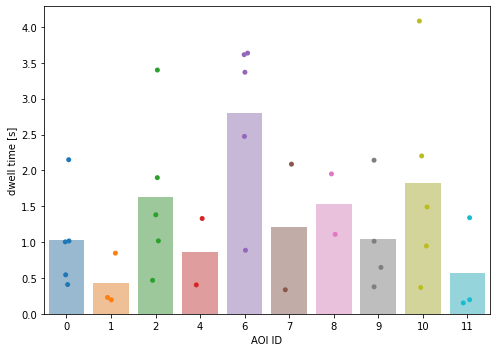

In [12]:
# plot the average time spent on each image
dwell_time_fig = plt.figure(figsize=(7, 5))

sns.barplot(
    x="AOI",
    y="duration [s]",
    data=dwell,
    ci=None,
    ax=plt.gca(),
    alpha=0.5,
)

sns.stripplot(
    x="AOI", 
    y="duration [s]", 
    data=dwell, 
    ax=plt.gca()
)

plt.ylabel("dwell time [s]")
plt.xlabel("AOI ID")
plt.tight_layout()

## Alternative Visualizations
In some contexts, it might make sense to show the aggregates metrics directly on the reference image. To this end, we make a more complicated plot in which we color the patch on the AOI by the hit rate, and plot all fixations on top. 

In [13]:
# define a function to map aoi id to color
def map_colors(idx, length, colors, fallback=[1, 1, 1, 1]):
    """
    This funcion maps the AOI ids to colors,
    using white as default color for fixations outside an AOI.
    """
    try:
        rgb = colors(idx / length)
    except TypeError:
        rgb = fallback
    return rgb

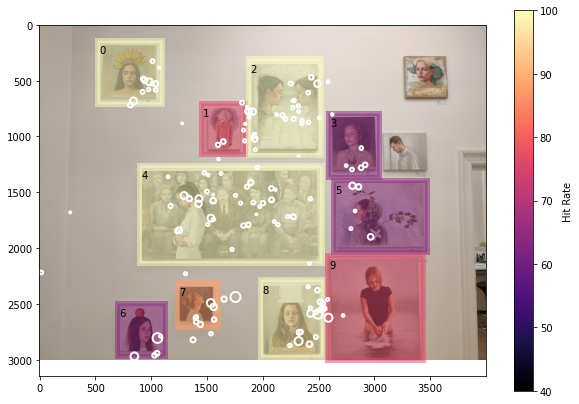

In [56]:
# initalize the figure
aoi_fig = plt.figure(figsize=(10, 7))

# show the reference image
plt.imshow(np.asarray(reference_image))

# intialize the colormap
cm = matplotlib.cm.get_cmap("magma")

# remove aois that were never looked at
looked_at_aois = aois[proportional_hits["AOI"]]

# define hit data
hit_data = proportional_hits["hit"]

# plot the aois
plot_color_patches(
    looked_at_aois,
    hit_data,
    plt.gca(),
    patch_colors=cm,
    max_value=100,
    alpha=0.5,
)

# plot fixations at their x- and y-position
plt.scatter(
    fixations["fixation x [px]"],
    fixations["fixation y [px]"],
    # change the face- and edgecolor to get circles rather than dots
    edgecolor="white",
    facecolor="none",
    linewidth=2,
    # set the size of the circles relative to the duration of each fixation
    # (the longest fixation has 100 px radius)
    s=fixations["duration [ms]"] / max(fixations["duration [ms]"]) * 100,
)

# show the colorbar
norm = mpl.colors.Normalize(vmin=np.min(hit_data), vmax=np.max(hit_data))

plt.colorbar(
    mpl.cm.ScalarMappable(
        norm=norm,
        cmap=cm,
    ),
    label="Hit Rate",
);

Note that AOIs that were never looked at will not be shown in this visualization.

## Conclusion

You have seen an approach to manually mark AOIs on an image, find fixations with x/y coordinates inside these images and summarize fixation metrics. The approach will work for any setup where your gaze coordinates are aligned with the coordinates of a given reference image.